## YOLOv3
- download model weights and cfgs at https://pjreddie.com/darknet/yolo/
- reference: https://medium.com/@luanaebio/detecting-people-with-yolo-and-opencv-5c1f9bc6a810

In [1]:
import cv2
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import glob
import time

In [2]:
def read_image(base_path, image_id, print_size=False):
    file_path = '%s/%d.jpg' % (base_path, image_id)
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    width = image.shape[1]
    height = image.shape[0]
    
    if print_size:
        print("Image %d: %d x %d " % (image_id, width, height))
    
    return image, width, height

In [9]:
def plot_image(indices, boxes, confidences, classes, pct_area, image, image_id):
    for i in indices:
        box = boxes[i[0]]
        label = str(classes[0]) 
        # pt1, pt2, color, thickness
        cv2.rectangle(image, 
                      (round(box[0]), round(box[1])), 
                      (round(box[0] + box[2]), round(box[1] + box[3])), 
                      (255, 0, 0), 2)
    
    if len(confidences) == 0:
        avg_conf = 0
    else:
        avg_conf = np.mean(confidences)
    
    plt.figure()
    plt.title("Image {}: {:.0%} of area is classified as person at {:.0%} confidence".format(
                    image_id, pct_area, avg_conf)
    )
    plt.imshow(image)
    plt.show()
    plt.close()

In [4]:
def create_bounding_box(classes, image, image_id, width, height, output, 
                        conf_threshold=0.1, plot=True):
    """
    # only filter the box with high confidence to classified as person (class_id=0)
    """
    confidences = []
    boxes = []
    area, pct_area = 0, 0

    for out in output:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
    
            if class_id == 0:
                confidence = scores[class_id]
                if confidence > conf_threshold:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])
                    area += (w * h)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)
    
    if area > 0:
        area /= len(boxes)
        pct_area = area / (width * height)
        
    if plot:
        plot_image(indices, boxes, confidences, classes, pct_area, image, image_id)
    
    return confidences, boxes, pct_area

## Detection criteria
- Hyperparameters to classify the image contains human
    - confidence threshold of bounding box: 0.2
    - The area of bounding box occupies more than 5% of the image

## YOLO Performance on 100 images
- YOLOv3-320: Accuracy: 89%. Total time used: 1 min. Same performance of yolov3-320 and yolov3-608.
- Fail reasons
    - Classify clothing as person: Image 132, 143, 163, 260, 289, 309, 311, 320
    - Human figure is too small: Image 24
    - The part of human body is amplified: Image 688
    - Most of the human body is covered by cloths: Image 283
- **Pros**
    - Fast and efficient. Easy to control hyperparameters. No need to consume disk space.
- **Cons**
    - YOLO cannot distinguish clothing from human when the shape is very similar, which is commonly seen in clothing product images.

## Comparison with human parsing
- YOLO performs better than human parsing at cases when most of the human body is covered by cloths.
- Human parsing performs better when YOLO wrongly classifies clothes into person.

In [6]:
# load COCO class names
classes = None
with open('../model/coco.names.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]
    
# use YOLOv3-320 pre-trained model
net = cv2.dnn.readNet('model/yolov3-320.weights', 'model/yolov3-320.cfg')

# get image_ids
images_ids = [int(x.split("/")[-1].split(".")[0]) for x in glob.glob('images/*.jpg')]
images_ids.sort()

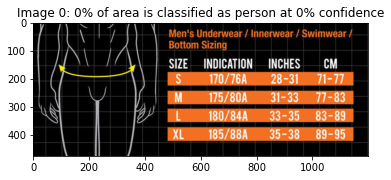

The image does not contain person 



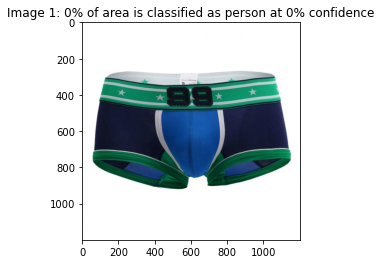

The image does not contain person 



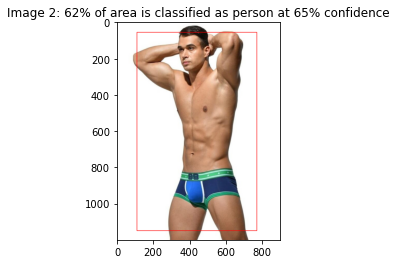

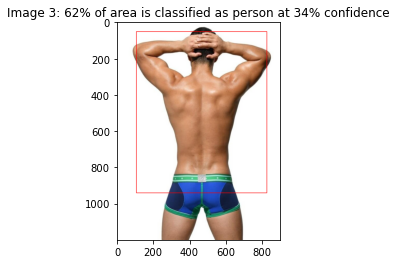

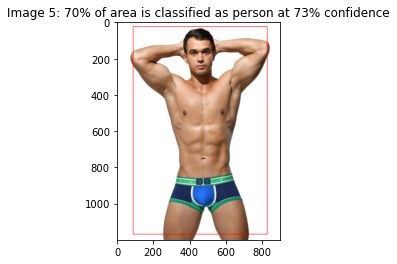

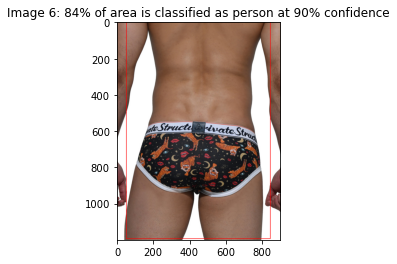

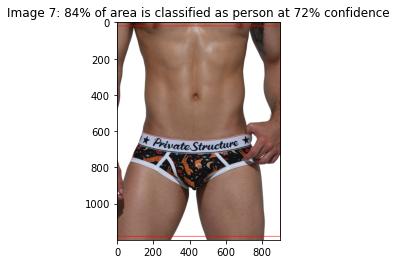

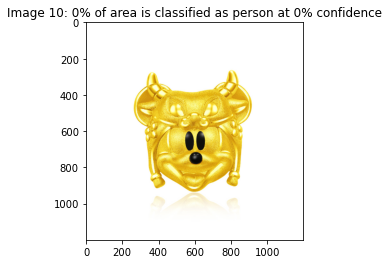

The image does not contain person 



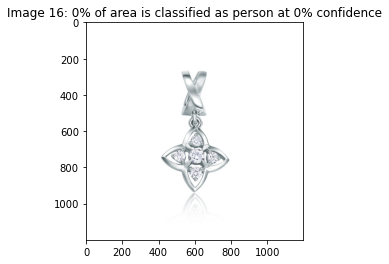

The image does not contain person 



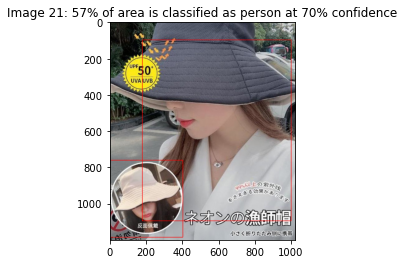

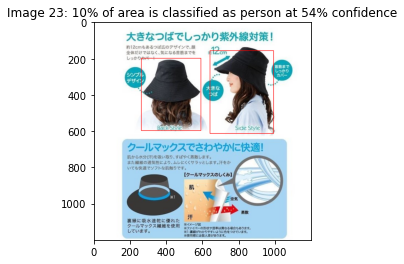

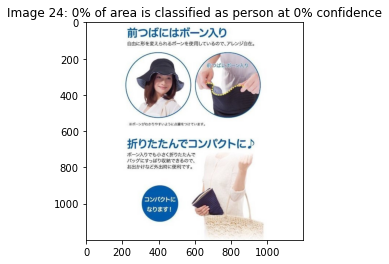

The image does not contain person 



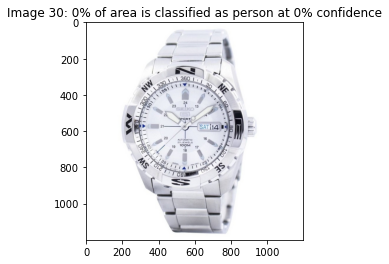

The image does not contain person 



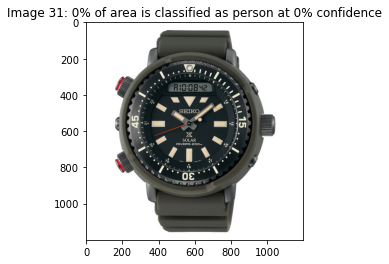

The image does not contain person 



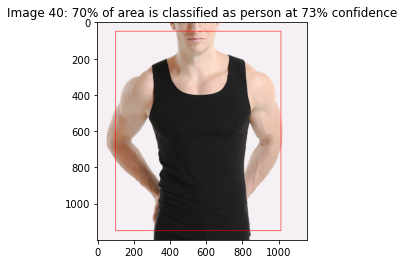

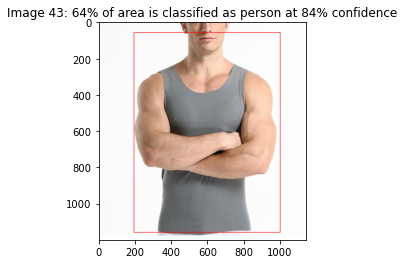

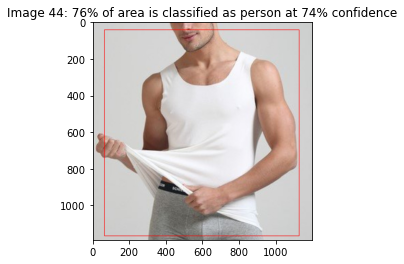

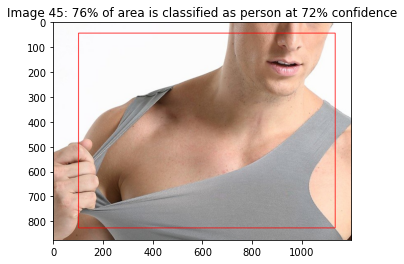

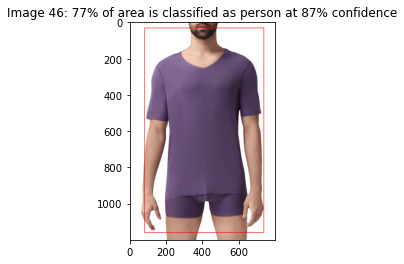

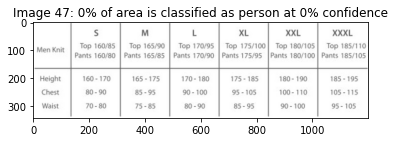

The image does not contain person 



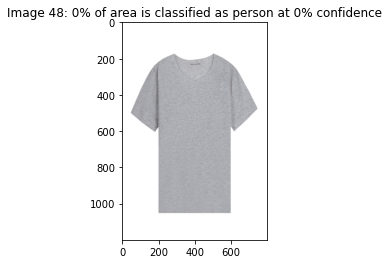

The image does not contain person 



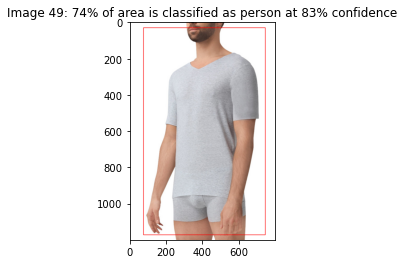

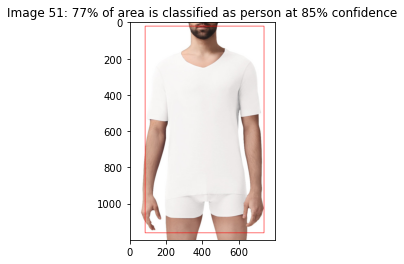

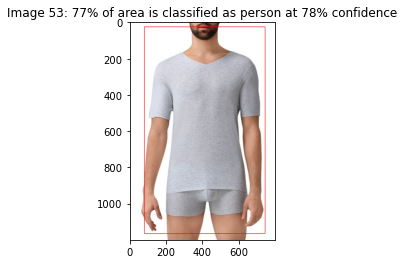

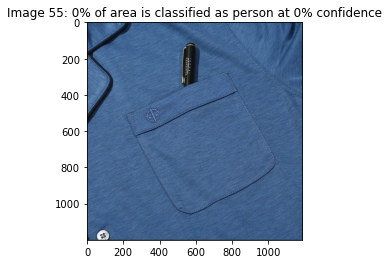

The image does not contain person 



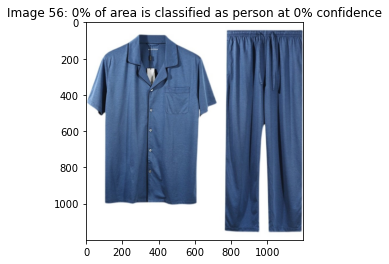

The image does not contain person 



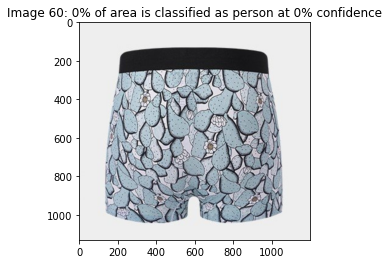

The image does not contain person 



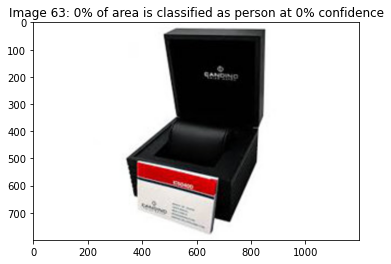

The image does not contain person 



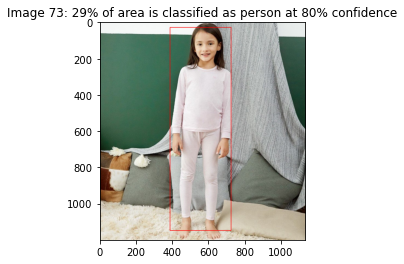

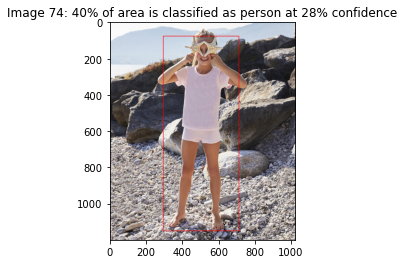

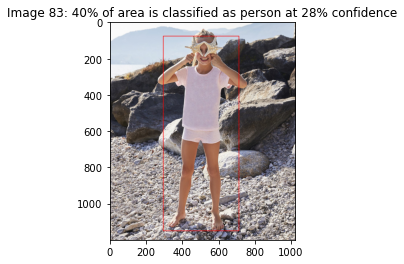

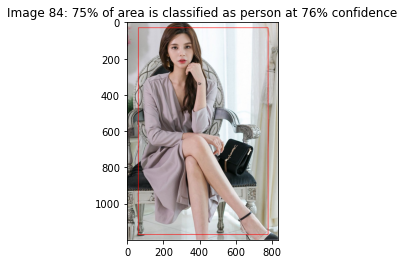

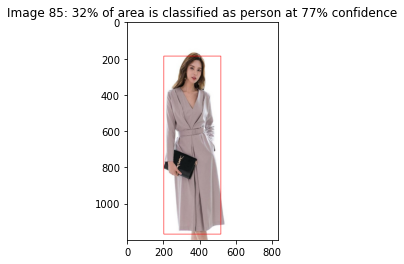

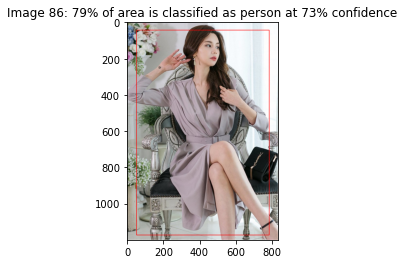

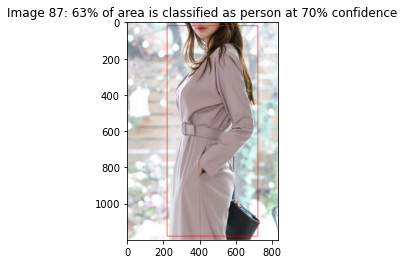

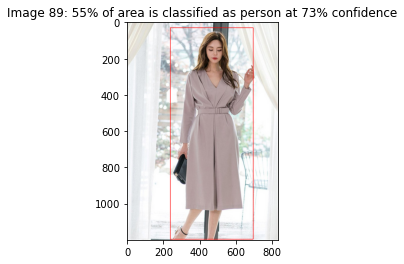

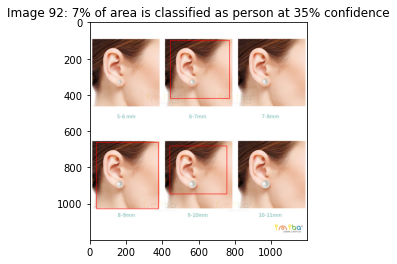

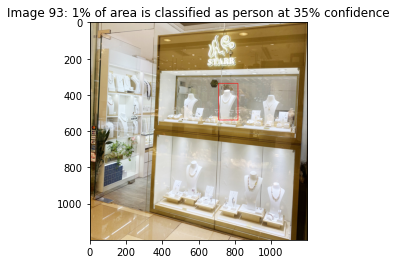

The image does not contain person 



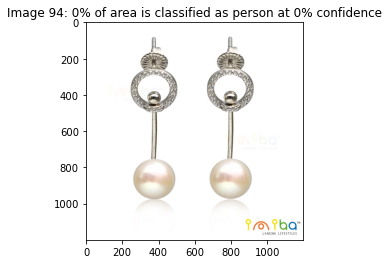

The image does not contain person 



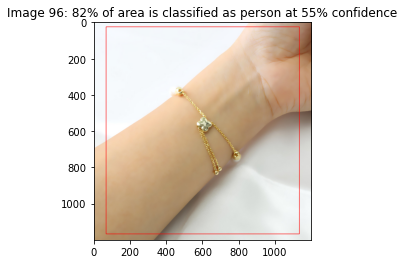

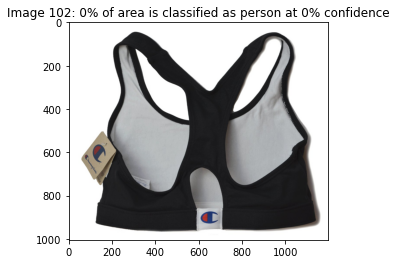

The image does not contain person 



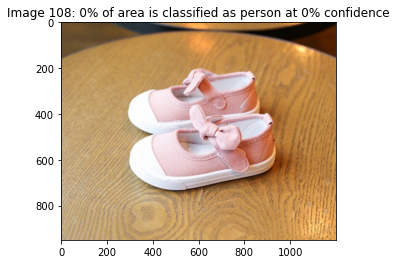

The image does not contain person 



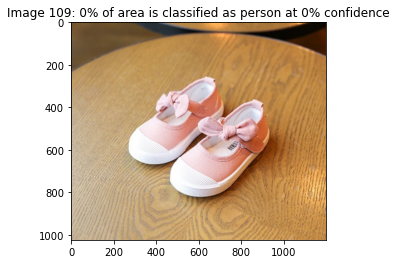

The image does not contain person 



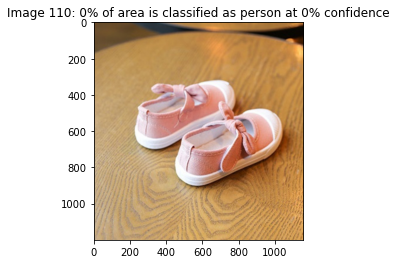

The image does not contain person 



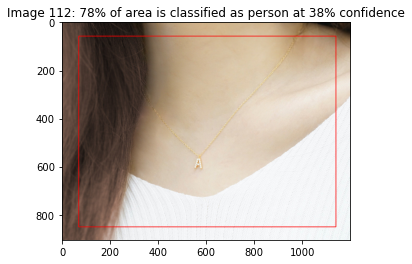

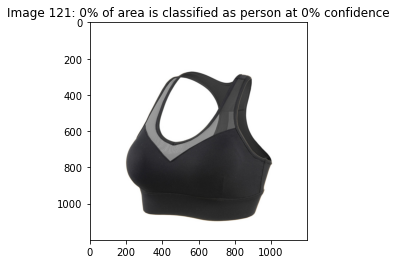

The image does not contain person 



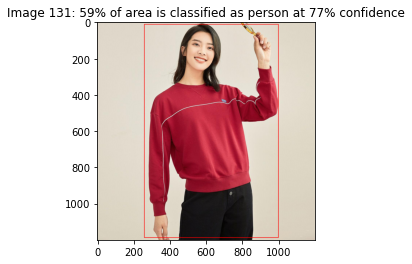

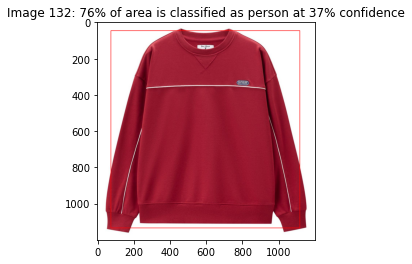

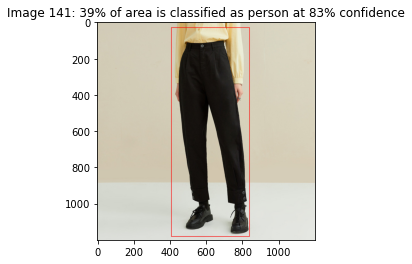

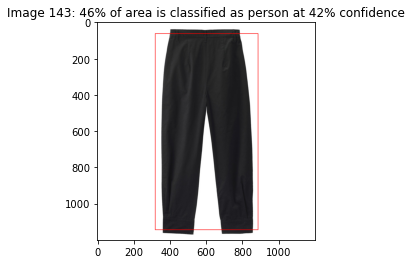

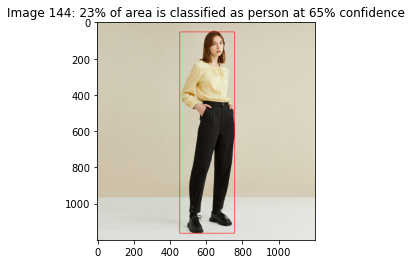

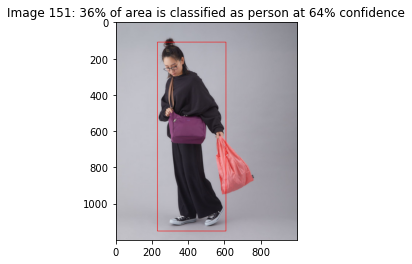

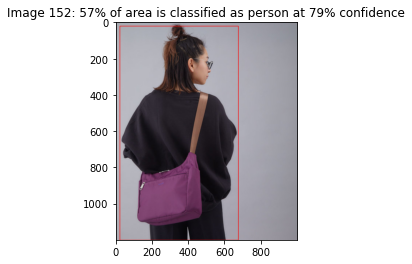

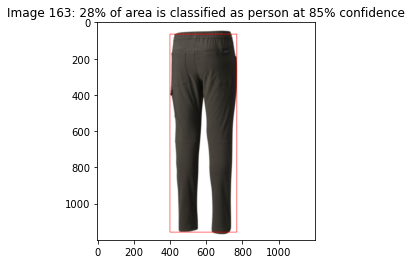

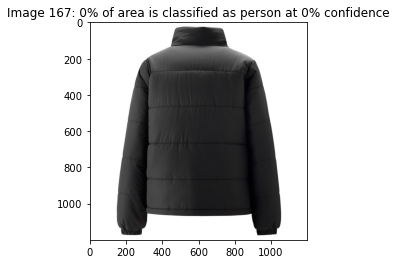

The image does not contain person 



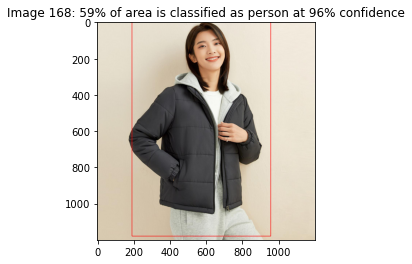

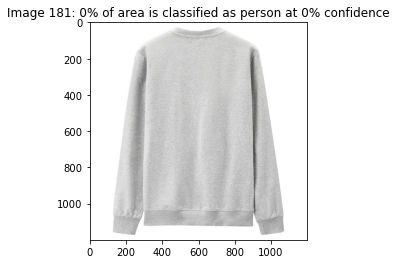

The image does not contain person 



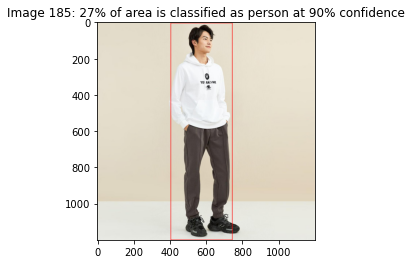

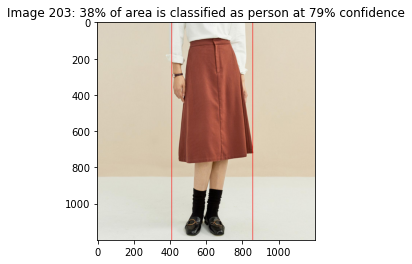

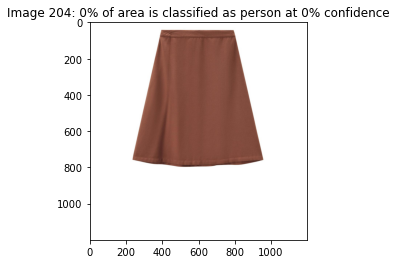

The image does not contain person 



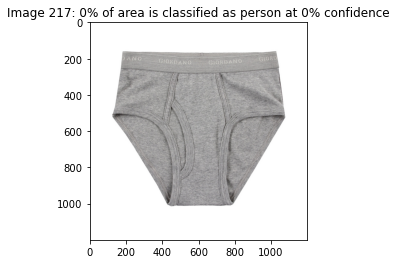

The image does not contain person 



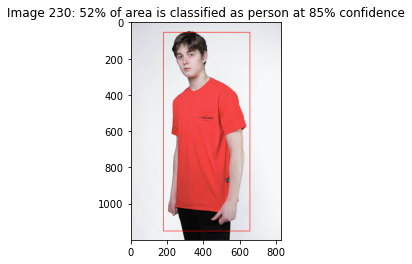

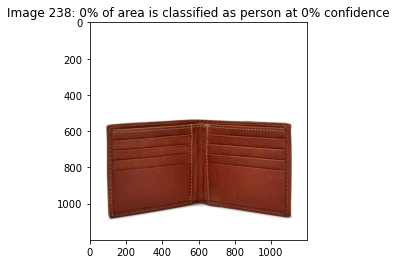

The image does not contain person 



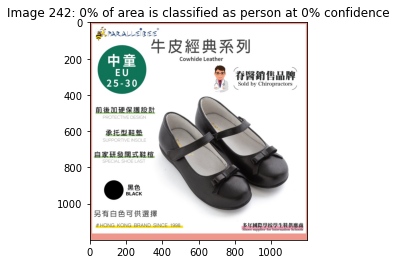

The image does not contain person 



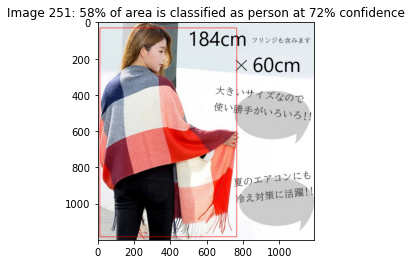

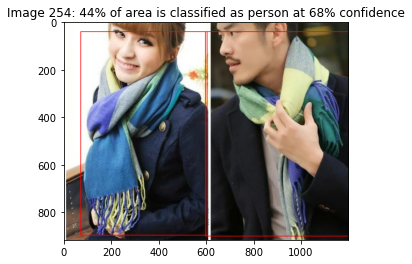

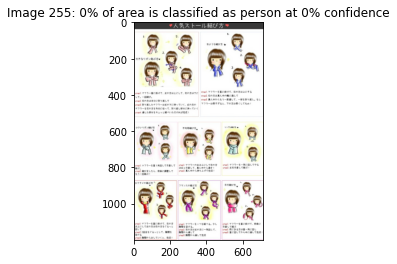

The image does not contain person 



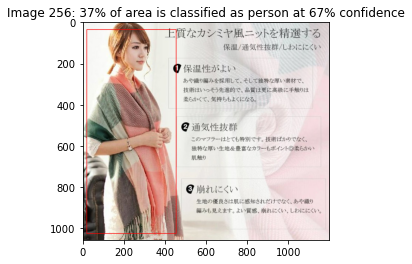

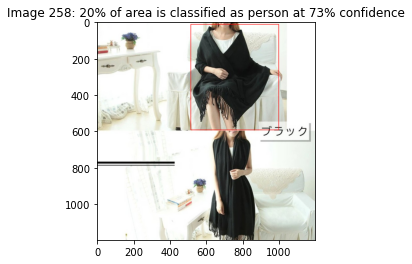

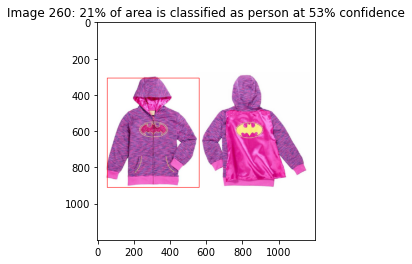

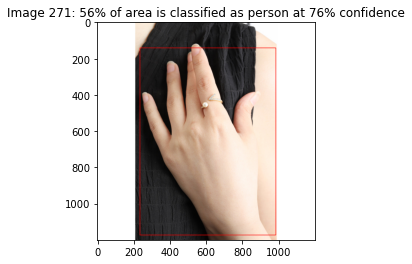

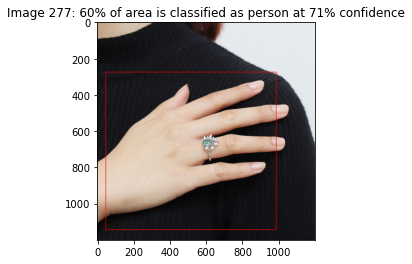

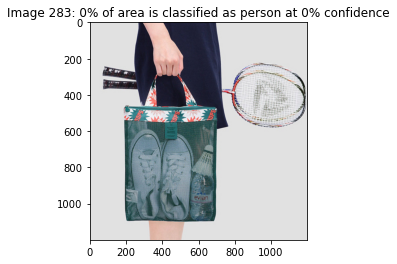

The image does not contain person 



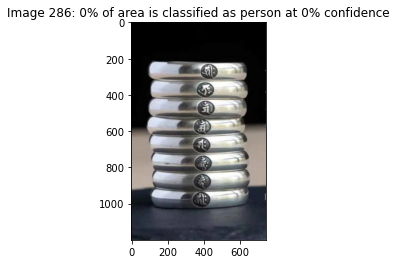

The image does not contain person 



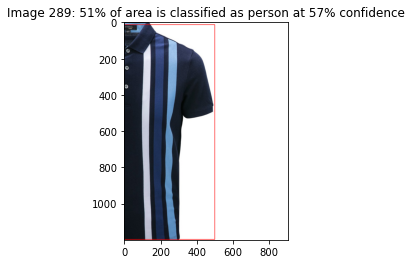

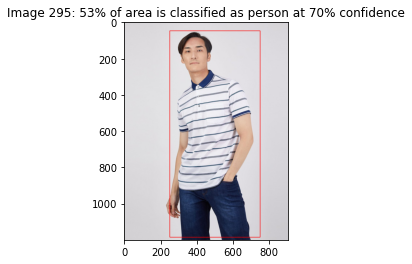

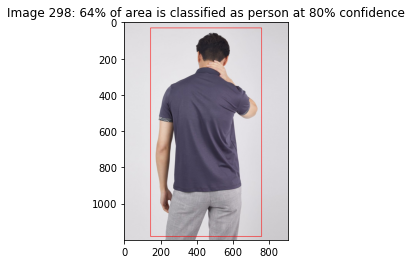

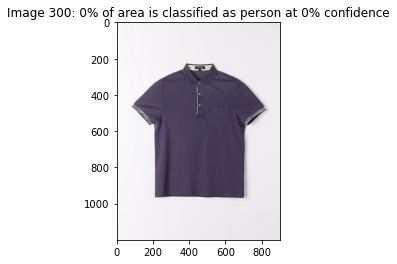

The image does not contain person 



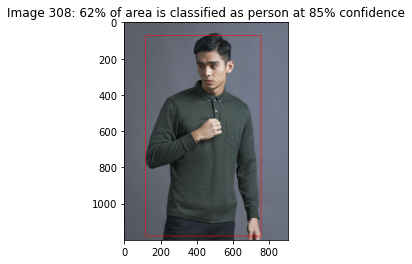

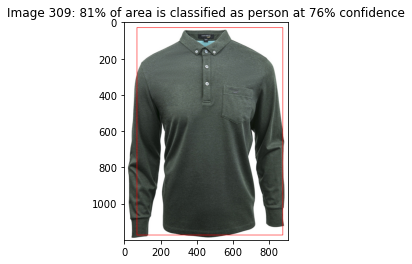

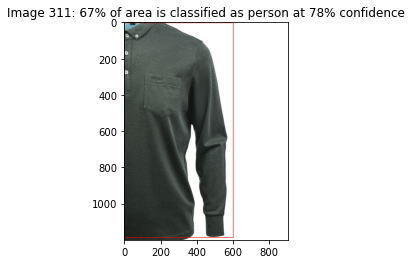

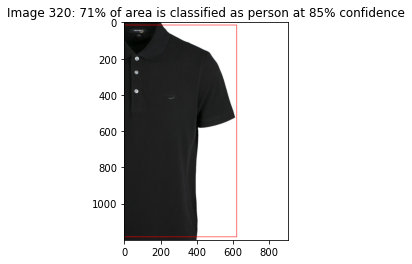

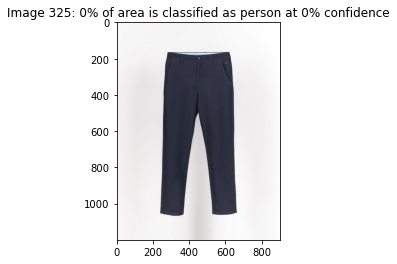

The image does not contain person 



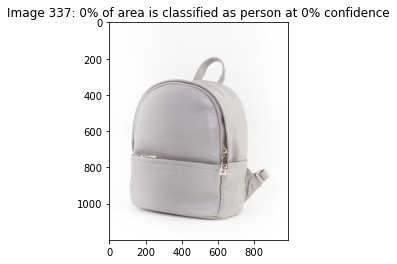

The image does not contain person 



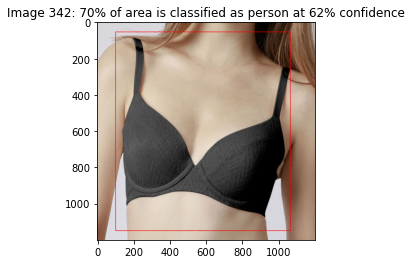

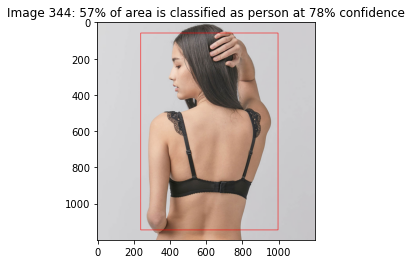

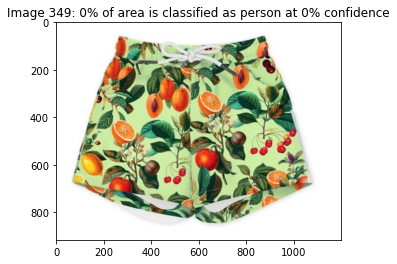

The image does not contain person 



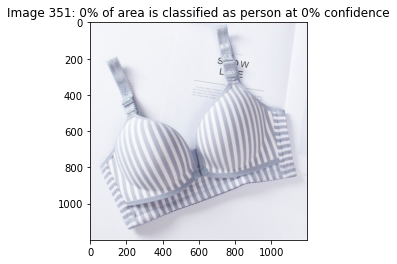

The image does not contain person 



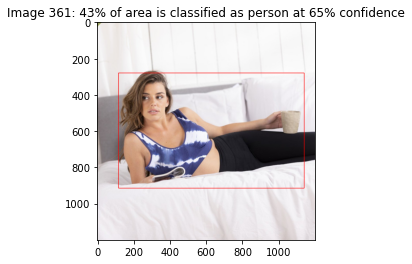

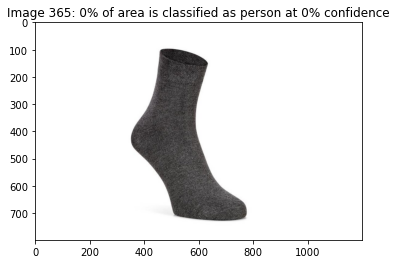

The image does not contain person 



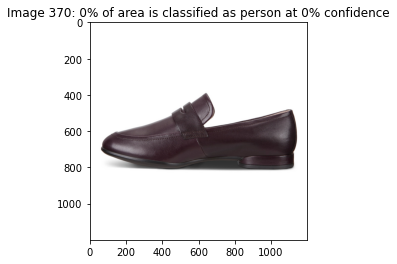

The image does not contain person 



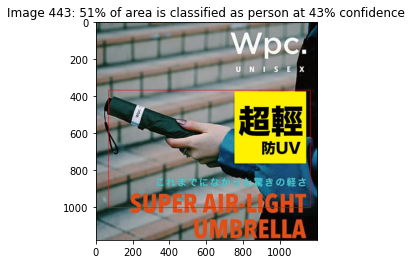

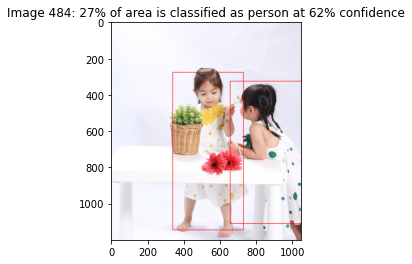

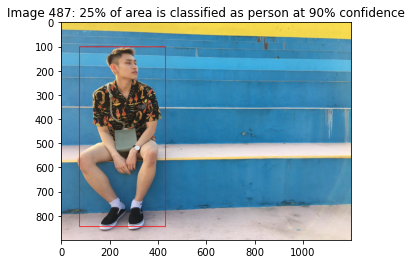

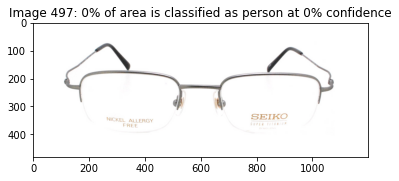

The image does not contain person 



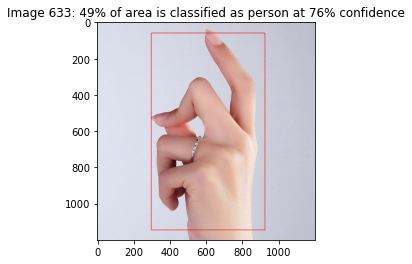

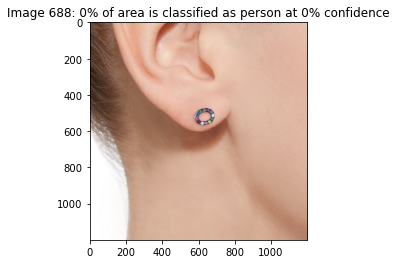

The image does not contain person 



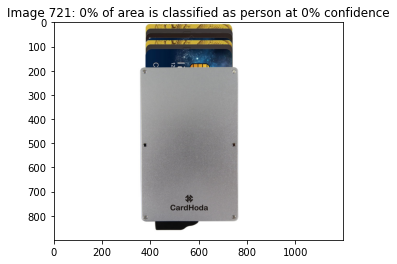

The image does not contain person 



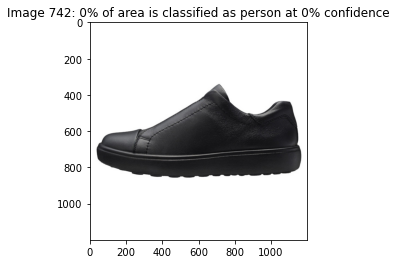

The image does not contain person 



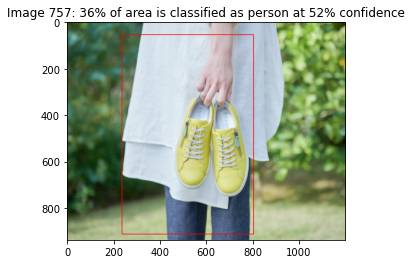

Total time used: 73.1872


In [10]:
result_dict = {"image_id": [], "confidence": [], "box_area": [], "yolo_pred": []}

start = time.time()

for image_id in images_ids:
    result_dict["image_id"].append(image_id)
    image, w, h = read_image('images', image_id, print_size=False)

    net.setInput(cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False))

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    outs = net.forward(output_layers)

    confs, boxes, pct_area = create_bounding_box(classes, image, image_id, w, h, outs, 
                                                 conf_threshold=0.2, plot=True)
    if len(confs) == 0 or pct_area < 0.05:
        print("The image does not contain person \n")
        result_dict["confidence"].append(0)
        result_dict["box_area"].append(0)
        result_dict["yolo_pred"].append(0)
    else:
        result_dict["confidence"].append(round(np.mean(confs), 4))
        result_dict["box_area"].append(round(pct_area, 4))
        result_dict["yolo_pred"].append(1)
    
end = time.time()
print("Total time used: %.4f" % (end - start))
    
result_df = pd.DataFrame.from_dict(result_dict, orient="columns")
result_df = result_df.sort_values("image_id")
result_df.to_csv("result/yolo_320_pred.csv", index=False)

### Comparison with human parsing method

In [127]:
yolo_res = pd.read_csv("result/yolo_320_pred.csv")
par_res = pd.read_csv("result/human_parsing_pred.csv")
label = pd.read_csv("result/true_label.csv")

res = yolo_res.merge(par_res, on="image_id")\
              .merge(label, on="image_id")


In [128]:
yolo_acc = np.mean(res["yolo_pred"] == res["y_true"])
pars_acc = np.mean(res["par_pred"] == res["y_true"])

print("yolo accuracy: {:.2%}".format(yolo_acc))
print("human parsing accuracy: {:.2%}".format(pars_acc))

yolo accuracy: 89.00%
human parsing accuracy: 85.00%


- Human parsing performs better when YOLO wrongly classifies clothes into person.

In [125]:
res[res["yolo_pred"] != res["y_true"]][["image_id", "confidence","yolo_pred", "par_pred", "y_true"]]


image_id  confidence  yolo_pred  par_pred  y_true
11        24      0.0000          0         0       1
47       132      0.3673          1         0       0
49       143      0.4210          1         0       0
53       163      0.8482          1         0       0
69       260      0.5268          1         0       0
72       283      0.0000          0         0       1
74       289      0.5746          1         0       0
79       309      0.7638          1         0       0
80       311      0.7795          1         0       0
81       320      0.8489          1         0       0
96       688      0.0000          0         1       1

- YOLO performs better than human parsing at cases when most of the human body is covered by cloths.

In [126]:
res[res["par_pred"] != res["y_true"]][["image_id", "yolo_pred", "pct_pixel", "par_pred", "y_true"]]


image_id  yolo_pred  pct_pixel  par_pred  y_true
10        23          1     0.0390         0       1
11        24          0     0.0405         0       1
28        73          1     0.0472         0       1
32        85          1     0.0400         0       1
39        96          1     0.0332         0       1
40       102          0     0.2926         1       0
48       141          1     0.0032         0       1
50       144          1     0.0168         0       1
51       151          1     0.0188         0       1
57       185          1     0.0147         0       1
58       203          1     0.0265         0       1
64       251          1     0.0433         0       1
68       258          1     0.0370         0       1
72       283          0     0.0401         0       1
99       757          1     0.0353         0       1